# p-value consistency benchmark

Test p-value consisency for GSEApy and blitzGSEA. 

In [13]:
%%capture
!pip3 install -q --user --force git+https://github.com/MaayanLab/blitzgsea.git
!pip3 install numpy==1.20

In [30]:
import importlib

import blitzgsea as blitz
importlib.reload(bgsea)

import time
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

## Load signature and GMT

The gene expression signature is calculated from GTEX samples comparing young vs old individuals. The gene set library is downloaded from Enrichr.

In [ ]:
# download example GMT file from Enrichr
url = "https://github.com/MaayanLab/blitzgsea/raw/main/testing/ageing_muscle_gtex.tsv"
urllib.request.urlretrieve(url, "ageing_muscle_gtex.tsv")

# read signature as pandas dataframe
signature = pd.read_csv("ageing_muscle_gtex.tsv")

# list available gene set libraries in Enrichr
blitz.enrichr.print_libraries()

# use enrichr submodule to retrieve gene set library
library = blitz.enrichr.get_library("KEGG_2019_Mouse")

## Wrapper function to limit memory consumption of GSEApy

The memory requirements of GSEApy exceed 32GB for larger gene set libraries. Limit the number of gene sets that are calculated at once.

In [4]:
import gseapy

def chopped_gsea(rnk, gene_sets, processes, permutation_num=100, max_lib_size=100, outdir='test/prerank_report_kegg', format='png', seed=1):
    library_keys = list(gene_sets.keys())
    chunks = [library_keys[i:i+max_lib_size] for i in range(0, len(library_keys), max_lib_size)]
    results = []
    for chunk in chunks:
        tlib = {}
        for k in chunk:
            tlib[k] = gene_sets[k]
        pre_res = gseapy.prerank(rnk=rnk, gene_sets=tlib, processes=processes, permutation_num=permutation_num, outdir=outdir, format=format, seed=seed)
        results.append(pre_res.res2d)
    return pd.concat(results)

sig = signature.sort_values(1, ascending=False)
sig = signature[~signature.index.duplicated(keep='first')]


## Calculate GSEA 10 times with random seeds

GSEA is computed for several permutation numbers starting at 250 permutations and up to 2500. This step can take long (several hours) due to 100 repetitions.

In [8]:
escores_old = []
escores_new = []

old_t = []
new_t = []

for i in range(1,11):
    boot_old = []
    boot_new = []
    tto = []
    ttn = []
    print(i)
    for j in range(1,11):
        ii=i*250
        st = time.time()
        res = blitz.gsea(signature, library, permutations=ii, processes=6, seed=j*i, signature_cache=False)
        ttn.append(time.time()-st)
        st = time.time()
        enrichment = chopped_gsea(sig, library, 3, permutation_num=ii, seed=i*j+j, max_lib_size=25)
        tto.append(time.time()-st)
        over = list(set(enrichment.index).intersection(set(res.index)))

        boot_new.append(np.array(res.loc[over,"pval"]).astype("float"))
        boot_old.append(np.array(enrichment.loc[over,"pval"]).astype("float"))
    
    escores_old.append(boot_old)
    escores_new.append(boot_new)
    old_t.append(tto)
    new_t.append(ttn)

1


Enrichment : 100%|██████████| 302/302 [00:00<00:00, 1150.77it/s]


2


Enrichment : 100%|██████████| 302/302 [00:00<00:00, 1195.82it/s]


3


Enrichment : 100%|██████████| 302/302 [00:00<00:00, 1177.32it/s]


4


Enrichment : 100%|██████████| 302/302 [00:00<00:00, 1178.06it/s]


5


Enrichment : 100%|██████████| 302/302 [00:00<00:00, 1171.60it/s]


6


Enrichment : 100%|██████████| 302/302 [00:00<00:00, 1164.82it/s]


7


Enrichment : 100%|██████████| 302/302 [00:00<00:00, 1148.39it/s]


8


Enrichment : 100%|██████████| 302/302 [00:00<00:00, 1172.50it/s]


9


Enrichment : 100%|██████████| 302/302 [00:00<00:00, 1170.09it/s]


10


Enrichment : 100%|██████████| 302/302 [00:00<00:00, 1169.45it/s]


## Save results

Pickle the results for later reuse.

In [9]:
import pickle
pickle.dump(escores_old, open("escores_old.pkl", "wb"))
pickle.dump(escores_new, open("escores_new.pkl", "wb"))

In [9]:
import pickle
escores_old = pickle.load(open("escores_old.pkl", 'rb'))
escores_new = pickle.load(open("escores_new.pkl", 'rb'))

## Plot results

Plot the error for GSEApy and blitzGSEA. The p-value error for fGSEA is computed in a separate notebook since it is running in a R environment.

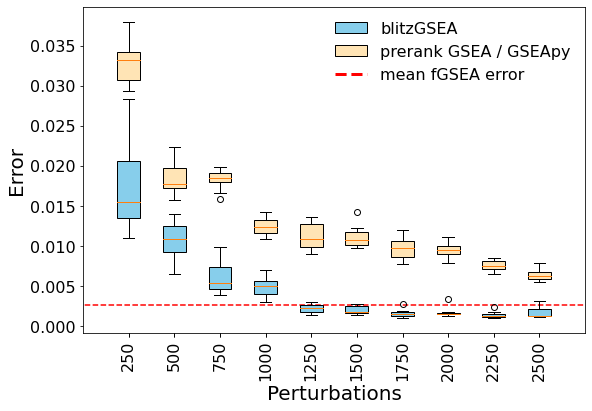

In [36]:
fgsea_error = [0.00261250354614742,0.00274601095318889,0.00268698398862981,0.00254896856733903,0.0028239254670881,0.00255107983368626,0.00266219682016753,0.00248607221489015,0.00294916957896707,0.00300309821889459]

error_new = []
for ll in range(len(escores_new)):
    ccc = np.log(pd.DataFrame(escores_new[ll])).T.corr()
    np.fill_diagonal(ccc.values, np.nan)
    error_new.append(1-ccc.mean())

error_old = []
for ll in range(len(escores_old)):
    ccc = np.log(pd.DataFrame(escores_old[ll])).T.corr()
    np.fill_diagonal(ccc.values, np.nan)
    error_old.append(1-ccc.mean())

fig = plt.figure(figsize =(9, 6))
ax = fig.add_subplot(111)

ax.hlines(np.mean(fgsea_error), -1, 12, color="red",linestyle="dashed", label="mean fGSEA error")
ax.set_xlim([0,11])

b1 = ax.boxplot(error_new, labels=np.array(range(1,len(escores_new)+1))*250, patch_artist=True)
b2 = ax.boxplot(error_old, labels=[""]*len(escores_new), patch_artist=True)

plt.xlabel("Perturbations", fontsize=20)
plt.ylabel("Error", fontsize=20)

for p in b1['boxes']:
    p.set_facecolor("skyblue")

for p in b2['boxes']:
    p.set_facecolor("moccasin")

ax.legend([b1["boxes"][0], b2["boxes"][0], Line2D([0], [0], color='r',linestyle="dashed", lw=3, label='mean fGSEA error')], ['blitzGSEA', 'prerank GSEA / GSEApy', 'mean fGSEA error'], loc='upper right', fontsize=16, frameon=False)

ax.tick_params(axis="x", labelsize=16, rotation=90)
ax.tick_params(axis="y", labelsize=16)

plt.savefig("figures/gsea_consistency_error.pdf", bbox_inches='tight')

## Plot p-value accuracy

Plot the p-value comparison of GSEApy and blitzGSEA. This plot shows that GSEApy saturates p-values.

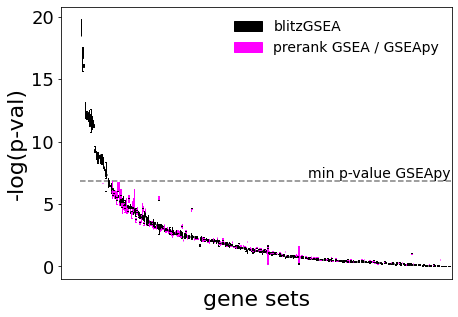

In [9]:
kk = 6

pp_new = -np.log(pd.DataFrame(escores_new[kk]).T)
ranks = pp_new.mean(axis=1).argsort()[::-1]

pp_old = -np.log(pd.DataFrame(escores_old[kk]).T)


fig = plt.figure(figsize =(7, 5))
ax = fig.add_subplot(111)

c = "black"
rl1 = ax.boxplot(pp_new.T.iloc[:, ranks], showfliers=False, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            medianprops=dict(color="black"), labels=[""]*len(ranks))


c = "magenta"
rl2 = ax.boxplot(pp_old.T.iloc[:, ranks], showfliers=False, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            medianprops=dict(color="black"), labels=[""]*len(ranks))

ax.hlines(np.max(np.max(pp_old.replace(np.inf, 0))), 0, pp_old.shape[0], color="grey", linestyles="--")
ax.text(pp_old.shape[0], np.max(np.max(pp_old.replace(np.inf, 0))), "min p-value GSEApy", fontsize=14, horizontalalignment='right', verticalalignment='bottom',)

ax.legend([rl1["boxes"][0], rl2["boxes"][0]], ['turboGSEA', 'prerank GSEA / GSEApy'], loc='upper right', fontsize=14, frameon=False)

plt.xlabel("gene sets", fontsize=22)
plt.ylabel("-log(p-val)", fontsize=22)

ax.tick_params(axis="x", labelsize=18, rotation=90)
ax.tick_params(bottom=False)
ax.tick_params(axis="y", labelsize=18)

plt.savefig("figures/pvalue_saturation.pdf", bbox_inches='tight')